The aim of this project will be to model the stellar variability of the Delta Scuti variable star, using timeseries data from the TESS mission to WASP-33b.

A Fourier analysis will be performed first. After that, a Lomb-Scargle periodigram will be produced, since it works best with unevenly sampled data.

The transit signals have already been removed from the dataset.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.fft as fft
import astropy
import webbrowser
from scipy.fft import fft, fftfreq
from astropy.timeseries import LombScargle

df = pd.read_csv("wasp-33b_residuals.csv")

Let's examine our dataset.

In [2]:
df

,time,residuals,flux_err
0,2.458792e+06,0.994566,0.001620
1,2.458792e+06,0.996258,0.001618
2,2.458792e+06,0.996416,0.001617
3,2.458792e+06,0.996009,0.001618
4,2.458792e+06,0.996739,0.001617
...,...,...,...
121457,2.459909e+06,1.001545,0.001609
121458,2.459909e+06,1.001408,0.001609
121459,2.459909e+06,1.000594,0.001611
121460,2.459909e+06,1.000998,0.001610


In the figure below that plots residuals versus time, we can see an uneven data set

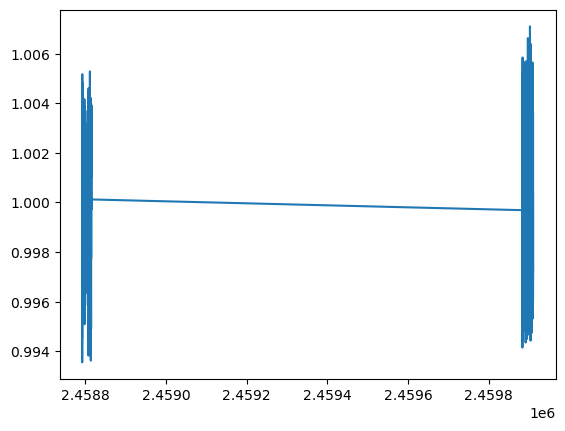

In [33]:
time = df['time']
residuals = df['residuals']

plt.plot (time,residuals)
plt.show()

Let's slice our data.

In [4]:
mask = df['time'] < df['time'].mean()

time1 = df['time'][mask]
time2 = df['time'][~mask]

In [5]:
residuals1 = df['residuals'][mask]
residuals2 = df['residuals'][~mask]

Let's visualize it to see where we are.

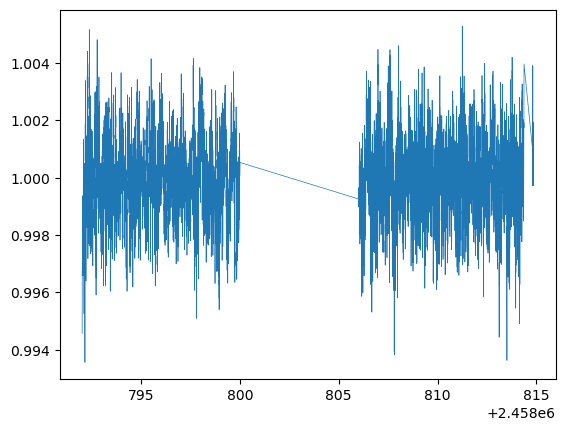

In [6]:
fig, ax = plt.subplots()
ax.plot(time1,residuals1, linewidth=0.5)
plt.show()

Better, but not quite there! Let's continue slicing.

In [7]:
mask_a = time1 < time1.mean()

time1_a = time1[mask_a]
time2_a = time1[~mask_a]

In [8]:
residuals1_a = residuals1[mask_a]
residuals2_a = residuals1[~mask_a]

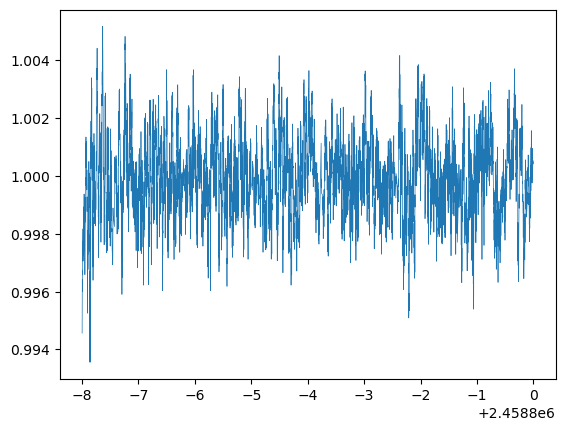

In [9]:
fig, ax = plt.subplots()
ax.plot(time1_a,residuals1_a, linewidth=0.5)
plt.show()

Beautiful! Now we have a dataset with which we can work!

The initial attempt at performing a Fourier transform failed. The data needed to be interpolated.

Now to interpolate our data!

In [10]:
min_time = np.min(time1_a)
print(min_time)

2458792.0008442705


In [11]:
max_time = np.max(time1_a)
print(max_time)

2458799.995281831


In [12]:
step = (max_time - min_time)/len(time1_a)

In [13]:
step

0.0014739007301694525

In [14]:
time_interp = np.linspace(min_time,max_time,len(time1_a))
resid_interp = np.interp(time_interp, time1_a, residuals1_a,)

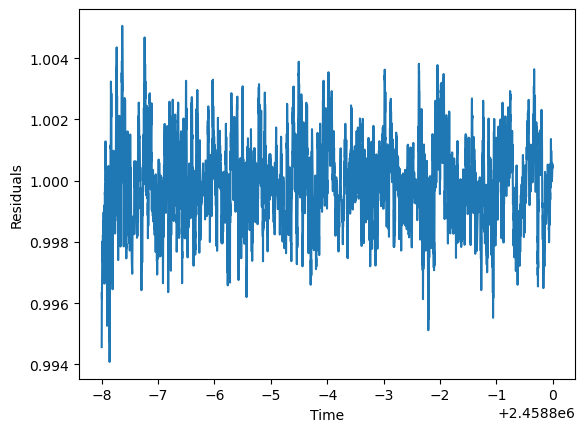

In [18]:
plt.plot(time_interp,resid_interp)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

We're now ready for our Fourier transform!

In [20]:
fourier_residuals = fft(resid_interp)

In [23]:
fourier_frequency = fftfreq(len(time1_a), step)[:len(time1_a)//2] #samples so that only uses real parts

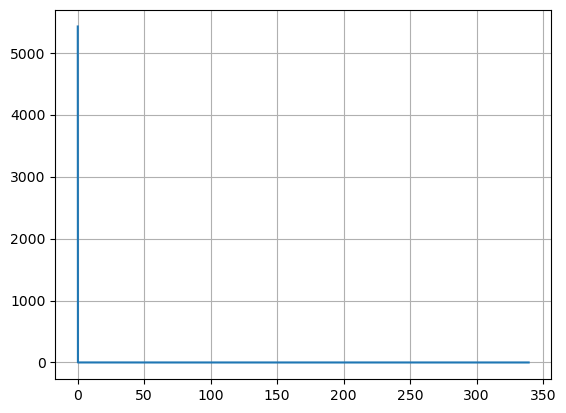

In [29]:
plt.plot(fourier_frequency, np.abs(fourier_residuals[0:len(time1_a)//2]))
plt.grid()
plt.show()

Uh-oh! Let's try to figure out what's wrong. The power seems to predominantly be in the lower frequency, which means that there is no periodic signal

To evaluate, let's take a look at the residuals.

In [30]:
fourier_residuals

array([ 5.42367335e+03-0.j        , -2.51172276e-01-0.07671249j,
       -6.66069813e-02-0.10211613j, ..., -1.58793976e-01-0.06794867j,
       -6.66069813e-02+0.10211613j, -2.51172276e-01+0.07671249j])

Let's ignore the first value. 

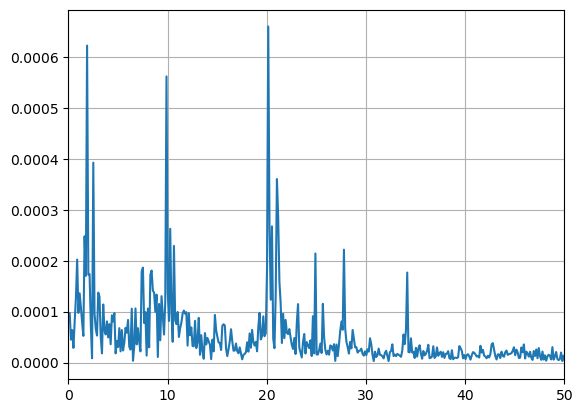

In [27]:
plt.xlim(0,50)
plt.plot(fourier_frequency[1:len(time1_a)//2], 2.0/len(time1_a) * np.abs(fourier_residuals[1:len(time1_a)//2])) #scaled by the frequency
plt.grid()
plt.show() 

Aaah! Much better!

Now, on to the Lomb-Scargle analysis! We'll work on the entire dataset, since the Lomb-Scarle method
is intended for uneven datasets.

Initial attempts found elements of NaN, so first we have to remove them.

In [34]:
num_time = time[~np.isnan(time)]
num_residuals = residuals[~np.isnan(time)]

An initial check showed that elements of NaN appeared more in time than residuals, so we had to adjust accordingly. The new check shows they are now equal arrays of equal length without elements of NaN.

In [35]:
print(len(num_time))
print(len(num_residuals))

121180
121180


In [36]:
print(len(time))
print(len(residuals))

121462
121462


In [37]:
LS_time, LS_residuals = LombScargle(num_time, num_residuals).autopower()

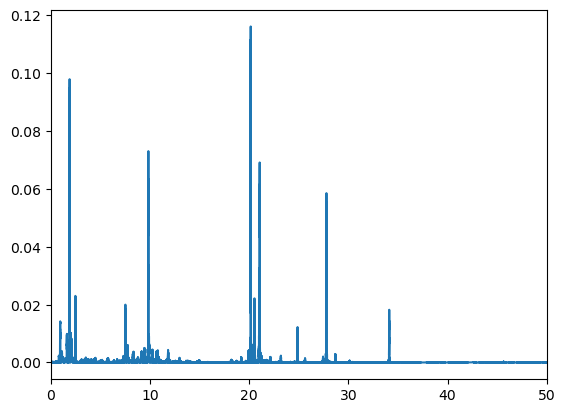

In [39]:
plt.xlim(0,50)
plt.plot(LS_time,LS_residuals)
plt.show()

This is interesting, because it shows similar results to the Fourier analysis that was conducted on only a small slice of the data, and yet the periods seem to be similar.